# `Baseline` - Multispecies Leaf Disease Classification 🍃 

## Objective 🎯
Train a machine learning model to identify diseased from healthy tree leaves. Initial model will perform a binary healthy / diseased classifier. Follow-on models will add categorical information to identify the species as well as health of the leaves.

## Introduction 📋
* The dataset from kaggle contains images of leaves from 11 species of trees such as `lemon`, `mango`, and `pomegranite`. 
* A total of `4503` jpeg image files at `6k X 4k RGB pixel resolution`
* `2273` healthy leaves and `2221` diseased leaves. 
* The dataset comes decomposed into training, testing, validation, and prediction images, therefore our EDA and model building will not further segregate data into training and other sets. 

The test and training labels are determined by the placement folder for each image file. For example, an image file stored in the folder "Guava diseased" is considered to have binary label = 1 to indicate a diseased leaf image. Based on this file folder location structure, our model will generate a binary label array.

### Baseline Results
For a simple NN binary classifier, we look at accuracy, recall and precision metrics across epochs. This seemed reasonable for a simple model to assess performance across epochs. We achieve an accuracy of 0.6. This could be a consequence of information loss from resizing images to 256x256 although also ran the model at 512x512 resolution without improvement in the performance therefore will proceed with 256x, lower resolution but faster performance. The accuracy varies from 0.5 to 0.8 across multiple runs and would have expected more consistency. This may indicate a problem with the baseline model. Runninc more epochs ( > 15) gives a more consistent 0.6 accuracy.

In [1]:
import pathlib
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import pandas as pd
import numpy as np

# ignore tensorflow & opencv debug & warning information by setting log level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow import keras
from keras import metrics
from keras import models
from keras import layers

from PIL import Image
import cv2



# import models created for baseline experiment
#from baseline_models import train_and_evaluate, build_model

## Data Engineering and featureset selection
### Notes regarding data engineering
Note 1: entry 4: Bael, has missing healthy images
        entry 8: Basil, has missing diseased images. 4 and 8 may be related. 
        Upon visual inspection the leaves look similar. We are going to assume entry 4 subdir name is a typo and should have been "Basil" rather than "Bael". We will rename subdir name from "Bael diseased (P4b)" to "Basil diseased (P8b)" 
        
Note 2: In the dataset from Kaggle, "Arjun" and "Alstonia Scholaris" subdirectories had P1b for healthy files and P1a for diseased files. This is inconsistent with the rest of the naming convention. As part of data engineering, renamed the subdirectory name to match.
        
Note 3: Alstonia Scholaris, upon visual inspection it seems healthy files are listed under the diseased sub-driectory and vice versa. As part of data engineering, we swapped location of the files. 

In [2]:
IMG_DIR: str = "Plants_2_compressed"

# ********************************************
# CHANGE PATH per LOCAL SETUP
# ********************************************
# store the filepath address of the current file
#__file__: str = os.path.abspath('')
__file__: str = os.path.abspath('D:\\MIDS\\W207\\Project')
    
#ROOT_DIR_PATH: str = os.path.join(pathlib.Path(__file__).parent.parent)
ROOT_DIR_PATH: str = os.path.join(pathlib.Path(__file__))
IMG_DIR_PATH: str = os.path.join(ROOT_DIR_PATH, "data", IMG_DIR)
    
# NOTE: entry 4: Bael, has missing healthy images
#       entry 8: Basil, has missing diseased images. 4 and 8 may be related. 
# NOTE 2: In the dataset from Kaggle Arjun subdirectory name had P1b for healthy files and P1a for diseased files. This is 
#         inconsistent with the rest of the naming convention. As part of data engineering, renamed the subdirectory name 
#         to match
file_subdir_name_list = ["NA","Arjun","Alstonia Scholaris","Gauva","Bael","Jamun","Jatropha","Pongamia Pinnata","Basil",
                     "Pomegranate","Lemon","Chinar"]

# if file_selector = 0 ==> select all files otherwise select file_set indicated
# ignore file_selector 4
# Valid selector values are 0, 1-3, 5-11
file_selector = 3

if file_selector == 0:
    print("Select All Filesets")
    IMG_DIR_PATH: str = os.path.join(ROOT_DIR_PATH, "data2", IMG_DIR)
    healthy_cand_spec: str  = "healthy"
    diseased_cand_spec: str = "diseased"
elif file_selector in range(1,4) or file_selector in range (5,12):
    healthy_cand_spec: str  = file_subdir_name_list[file_selector] + " healthy (P" + str(file_selector) + "a)"
    diseased_cand_spec: str = file_subdir_name_list[file_selector] + " diseased (P" + str(file_selector) + "b)"
    print(healthy_cand_spec)
    print(diseased_cand_spec)
else:
    print("ERROR: file set " + str(file_selector) + " NOT FOUND")
    
# Find image file names from local store directory
imgfiles_healthy_train: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "train", healthy_cand_spec))
imgfiles_diseased_train: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "train", diseased_cand_spec))
imgfiles_healthy_test: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "test", healthy_cand_spec))
imgfiles_diseased_test: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "test", diseased_cand_spec))
    
# ADD VALIDATION FILES
imgfiles_healthy_valid: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "valid", healthy_cand_spec))
imgfiles_diseased_valid: list[str] = os.listdir(os.path.join(IMG_DIR_PATH, "valid", diseased_cand_spec))
    
# Generate binary image labels: `0` = `healthy`, `1` = `diseased`
image_label_train: np.ndarray = np.zeros(len(imgfiles_healthy_train) + len(imgfiles_diseased_train))
image_label_train[len(imgfiles_healthy_train) :] = 1

image_label_test: np.ndarray = np.zeros(len(imgfiles_healthy_test) + len(imgfiles_diseased_test))
image_label_test[len(imgfiles_healthy_test) :] = 1

# ADD VALIDATION FILES
image_label_valid: np.ndarray = np.zeros(len(imgfiles_healthy_valid) + len(imgfiles_diseased_valid))
image_label_valid[len(imgfiles_healthy_valid) :] = 1

#Load images to memory, healthy images first then diseased images. 
images_training: list[np.ndarray] = []
images_test: list[np.ndarray] = []

images_valid: list[np.ndarray] = []

imgfiles_map: dict[str, list[str]] = dict(
    imgfiles_healthy_train=imgfiles_healthy_train, 
    imgfiles_diseased_train=imgfiles_diseased_train, 
    imgfiles_healthy_test=imgfiles_healthy_test, 
    imgfiles_diseased_test=imgfiles_diseased_test,
    imgfiles_healthy_valid=imgfiles_healthy_valid, 
    imgfiles_diseased_valid=imgfiles_diseased_valid
)
    
for imgfile_collection_name, imgfile_collection in imgfiles_map.items():
    #print("imgfile_collection_name " + imgfile_collection_name)
    #print("imgfile_collection " + str(imgfile_collection))
    
    batch_val: str = imgfile_collection_name.split("_")[-1]
    spec_feat: str = imgfile_collection_name.split("_")[-2]
    spec_feat_path: str = healthy_cand_spec if spec_feat == "healthy" else diseased_cand_spec
    
    #print("batch_val: " + batch_val)
    #print("spec_feat: " + spec_feat)
    #print("spec_feat_path: " + spec_feat_path)
    
    for imgf in imgfile_collection:
        f_path: str = os.path.join(IMG_DIR_PATH, batch_val, spec_feat_path, imgf)
            
        #print(f_path)
        
        im: np.ndarray = cv2.imread(f_path,1) # 1 ... read color, 0 ... greyscale, -1 ... unchanged
        #print(im.size)
        #cv2.imshow('image', im)
        
        if batch_val == "train":
            images_training.append(im) 
        elif batch_val == "test":
            images_test.append(im)
        else:
            images_valid.append(im)

Gauva healthy (P3a)
Gauva diseased (P3b)


In [3]:
# ********************************************************************
# UNIT TEST
# ********************************************************************
print(IMG_DIR_PATH + " train " + healthy_cand_spec)
print(ROOT_DIR_PATH)
print(IMG_DIR_PATH)
print(imgfiles_healthy_train)
#print(imgfiles_map.items())
print(len(images_training), len(images_test), len(images_valid))

D:\MIDS\W207\Project\data\Plants_2_compressed train Gauva healthy (P3a)
D:\MIDS\W207\Project
D:\MIDS\W207\Project\data\Plants_2_compressed
['0004_0011.JPG', '0004_0012.JPG', '0004_0013.JPG', '0004_0014.JPG', '0004_0015.JPG', '0004_0016.JPG', '0004_0017.JPG', '0004_0018.JPG', '0004_0019.JPG', '0004_0020.JPG', '0004_0021.JPG', '0004_0022.JPG', '0004_0023.JPG', '0004_0024.JPG', '0004_0025.JPG', '0004_0026.JPG', '0004_0027.JPG', '0004_0028.JPG', '0004_0029.JPG', '0004_0030.JPG', '0004_0031.JPG', '0004_0032.JPG', '0004_0033.JPG', '0004_0034.JPG', '0004_0035.JPG', '0004_0036.JPG', '0004_0037.JPG', '0004_0038.JPG', '0004_0039.JPG', '0004_0040.JPG', '0004_0041.JPG', '0004_0042.JPG', '0004_0043.JPG', '0004_0044.JPG', '0004_0045.JPG', '0004_0046.JPG', '0004_0047.JPG', '0004_0048.JPG', '0004_0049.JPG', '0004_0050.JPG', '0004_0051.JPG', '0004_0052.JPG', '0004_0053.JPG', '0004_0054.JPG', '0004_0055.JPG', '0004_0056.JPG', '0004_0057.JPG', '0004_0058.JPG', '0004_0059.JPG', '0004_0060.JPG', '0004_0061

## Preprocessing & EDA 🔭
#### For exploratory analysis, display 25 random images from the training set
The images are well centered with the leaf showing prominently at the center against a differentiable background.

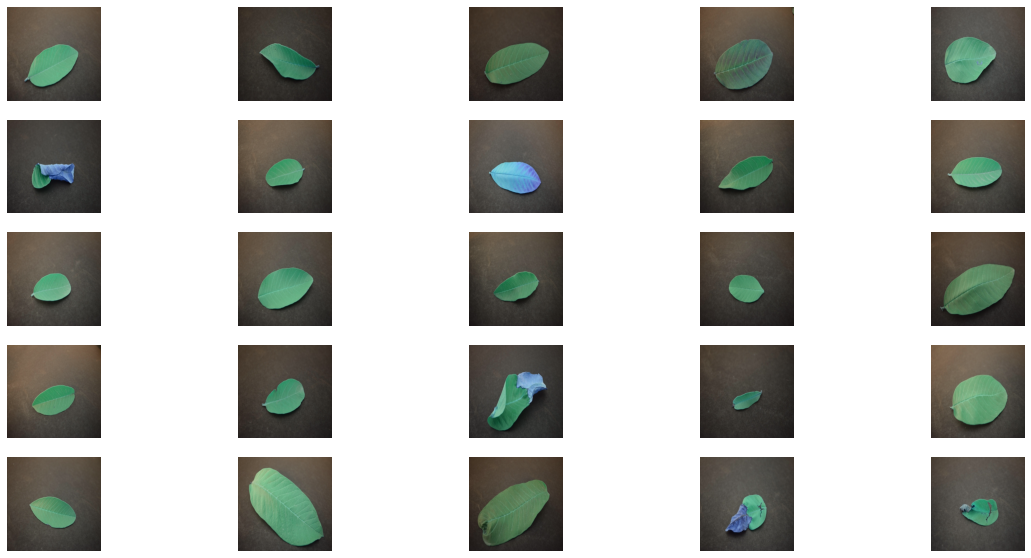

In [4]:
# Display some images
count = len(images_training) - 1

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,10))
for i in range(5):
    for j in range(5):
        indx = random.randint(0,count)
        axs[i][j].imshow(images_training[indx])
        axs[i][j].axis('off')
plt.show()

## ML Models
### Convolution Network Model Training and Evaluation
The following functions provide model building and training

In [5]:
# *************************************************
# FUNCTION DESCRIPTION
# 
# *************************************************

def build_model_cnn(
    n_classes=1,
    hidden_layer_sizes=[],
    activation="relu",
    optimizer="SGD",
    learning_rate=0.01,
):
    """
    Args:
        n_classes: Number of output classes in the dataset.
        hidden_layer_sizes: A list with the number of units in each hidden layer.
        activation: The activation function to use for the hidden layers.
        optimizer: The optimizer to use (SGD, Adam).
        learning_rate: The desired learning rate for the optimizer.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))


    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))


    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        name='conv_2',
        activation='relu'))

    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2), name='pool_2')
    )
    
    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units=1024,
        name='fc_1', 
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.1))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class membership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=1,
        name='fc_2',
        activation=None))


    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 256, 256, 3))
    model.summary()
    
    return model

In [6]:
# *************************************************
# FUNCTION DESCRIPTION
# 
# *************************************************
def train_cnn(
    hidden_layer_sizes=[],
    activation="tanh",
    optimizer="Adam",
    learning_rate=0.01,
    num_epochs=20,
    batch_size=32,
):

    # Build the model.
    
    model = build_model_cnn(
        n_classes=1,
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate,
    )


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 
    
    return model

In [7]:
model = train_cnn()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 64, 64, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 128)       102528    
                                                                 
 pool_2 (MaxPooling2D)       (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0

### Run the CNN Training and History
Preprocess the data to add data augmentation then execute model fit and evaluation functions.

In [8]:
# *************************************************
# FUNCTION DESCRIPTION
# Pre-process and add Data Augmentation
#
# ToDo: Match healthy and diseased image counts by 
# oversampling to add additional images 
# (flip, mirror, scale?, rotate?)
# *************************************************
def preprocess_train(X_train, Y_train):
    
    print("Starting data preprocessing ...")
    """
    Params:
    -------
    
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 256, 256, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    """
    
    IMAGE_SIZE = (256, 256)
    CONTRAST_FACTOR = 2
    DELTA = 0.2
   
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    print("Preprocess resize ...")
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
   
    # rescale image to [0,1]
    print("Preprocess rescale ...")
    X_train = X_train/255.0
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    print("Preprocess adjust brightness ...")
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    print("Preprocess adjust contrast ...")
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    print("Preprocess random flip ...")
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    X_train_augm = tf.image.random_flip_up_down(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    Y_train_augm = Y_train
    Y_train = tf.concat([Y_train, Y_train_augm],axis=0)
    
    #shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    #X_train = tf.gather(X_train, shuffle)
    #Y_train = tf.gather(Y_train, shuffle)

    return X_train, Y_train

In [9]:
FILE_BATCH_SIZE = 1000

num_images = len(images_training)
#print(int(num_images/1000))

X_train = np.zeros(())
Y_train = np.zeros(())

if (num_images > FILE_BATCH_SIZE):
    num_iter = int(num_images/FILE_BATCH_SIZE)
    rem_file_cnt = num_images % FILE_BATCH_SIZE
    print("preprocess run " + str(num_iter) + " iterations of " + str(FILE_BATCH_SIZE) + " files plus final iteration of " + str(rem_file_cnt) + " files")
    
    for iter in range(num_iter):
        print("running iteration " + str(iter))
        print(str(iter*FILE_BATCH_SIZE) + ":" + str(iter*FILE_BATCH_SIZE + FILE_BATCH_SIZE) )
        
        start = iter*FILE_BATCH_SIZE
        end = start + FILE_BATCH_SIZE
        X, Y = preprocess_train(images_training[start:end], image_label_train[start:end])
        
        if iter==0:
            X_train = X
            Y_train = Y
        else:       
            X_train = tf.concat([X_train, X],axis=0)
            Y_train = tf.concat([Y_train, Y],axis=0)
    
    print(str(iter*FILE_BATCH_SIZE + FILE_BATCH_SIZE) + ":" + str(num_images))
else:
    print("preprocess " + str(num_images) + " images")
    X_train, Y_train = preprocess_train(images_training, image_label_train)

preprocess 398 images
Starting data preprocessing ...
Preprocess resize ...
Preprocess rescale ...
Preprocess adjust brightness ...
Preprocess adjust contrast ...
Preprocess random flip ...


In [ ]:
# Preprocess training data in 1000 image chunks
X1, Y1 = preprocess_train(images_training[0:1000], image_label_train[0:1000])
X2, Y2 = preprocess_train(images_training[1000:2000], image_label_train[1000:2000])
X3, Y3 = preprocess_train(images_training[2000:3000], image_label_train[2000:3000])
X4, Y4 = preprocess_train(images_training[3000:4000], image_label_train[3000:4000])
X5, Y5 = preprocess_train(images_training[4000:], image_label_train[4000:])

In [ ]:
# concatenate preprocessed training data
X_train = X1
X_train = tf.concat([X_train, X2],axis=0)
X_train = tf.concat([X_train, X3],axis=0)
X_train = tf.concat([X_train, X4],axis=0)
X_train = tf.concat([X_train, X5],axis=0)

Y_train = Y1
Y_train = tf.concat([Y_train,Y2],axis=0)
Y_train = tf.concat([Y_train,Y3],axis=0)
Y_train = tf.concat([Y_train,Y4],axis=0)
Y_train = tf.concat([Y_train,Y5],axis=0)

In [ ]:
A = X1
A = tf.concat([A, X2],axis=0)

In [10]:
# *************************************************
# FUNCTION DESCRIPTION
# Pre-process and add Data Augmentation
#
# ToDo: Match healthy and diseased image counts by 
# oversampling to add additional images 
# (flip, mirror, scale?, rotate?)
# *************************************************
def preprocess_test(X_test, X_valid):
    
    print("Starting data preprocessing ...")
    
    IMAGE_SIZE = (256, 256)
    CONTRAST_FACTOR = 2
    DELTA = 0.2
   
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    print("Preprocess resize ...")
    
    X_valid = tf.image.resize(X_valid, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    print("Preprocess rescale ...")
    X_valid = X_valid/255.0
    X_test = X_test/255.0
    
    return X_test, X_valid

In [11]:
(X_test, X_valid) = preprocess_test(images_test, images_valid)

Starting data preprocessing ...
Preprocess resize ...
Preprocess rescale ...


In [12]:


Y_test = image_label_test
Y_valid = image_label_valid

shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
X_train = tf.gather(X_train, shuffle)
Y_train = tf.gather(Y_train, shuffle)
    
print("Training...")
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=12,
    validation_data=(X_valid,Y_valid)
)

Training...
Epoch 1/12
25/25 [==============================] - 18s 708ms/step - loss: 2.1112 - accuracy: 0.6382 - val_loss: 0.5692 - val_accuracy: 0.5000
Epoch 2/12
25/25 [==============================] - 18s 709ms/step - loss: 0.5444 - accuracy: 0.7161 - val_loss: 0.2785 - val_accuracy: 0.8000
Epoch 3/12
25/25 [==============================] - 18s 724ms/step - loss: 0.4994 - accuracy: 0.7412 - val_loss: 0.3747 - val_accuracy: 0.6000
Epoch 4/12
25/25 [==============================] - 18s 728ms/step - loss: 0.4233 - accuracy: 0.7952 - val_loss: 0.2491 - val_accuracy: 0.9000
Epoch 5/12
25/25 [==============================] - 18s 726ms/step - loss: 0.2902 - accuracy: 0.8580 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 6/12
25/25 [==============================] - 18s 726ms/step - loss: 0.2166 - accuracy: 0.9133 - val_loss: 0.0375 - val_accuracy: 1.0000
Epoch 7/12
25/25 [==============================] - 18s 730ms/step - loss: 0.1845 - accuracy: 0.9309 - val_loss: 0.0247 - val_accu

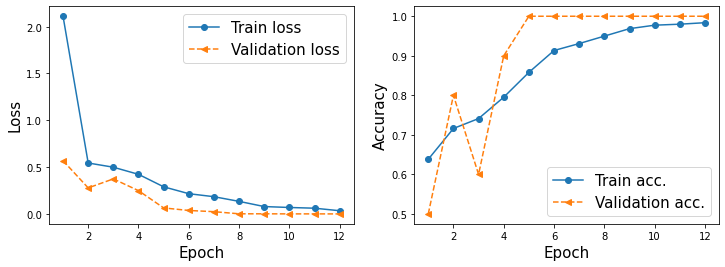

In [13]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

#### Display learning for each layer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


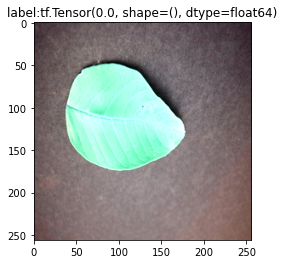

In [14]:
#print(X_train)
img_tensor = np.expand_dims(X_train[2], axis = 0);

# Print image tensor shape
#print('Shape of image:', img_tensor.shape);
  
# Print image
plt.imshow(img_tensor[0]);
plt.title('label:' + str(Y_train[1]))
plt.show()

#### Next we print what the model learns after each layer-channel

1/1 [==============================] - 2s 2s/step
----------------
Geeting activations of layer 1 : conv_1
Images size is 128 x 128
Number of channels is 32
Printing channels:


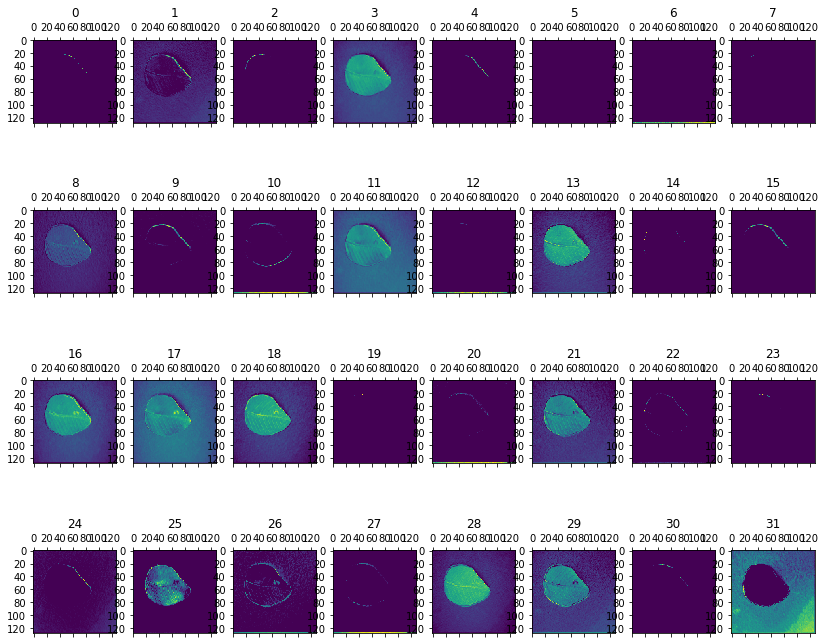

----------------
Geeting activations of layer 2 : pool_1
Images size is 64 x 64
Number of channels is 32
Printing channels:


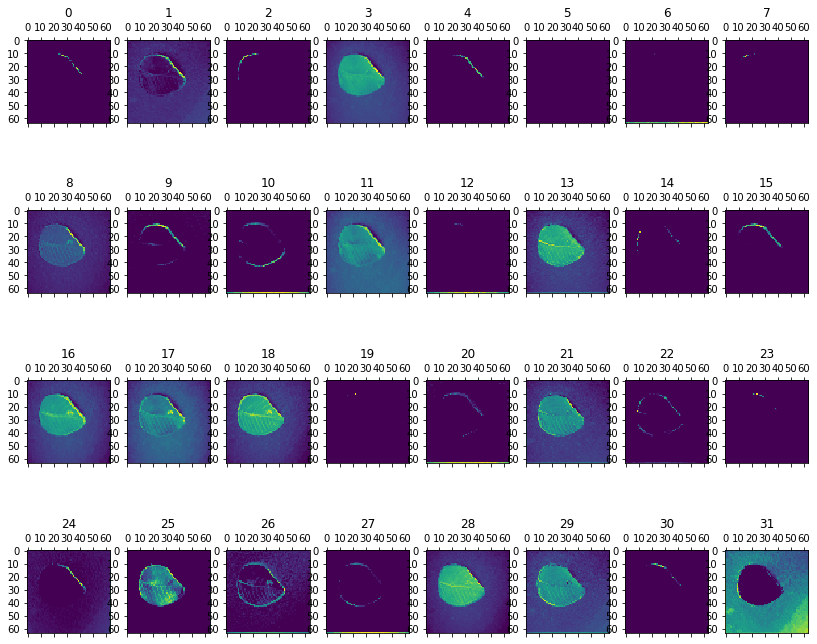

----------------
Geeting activations of layer 3 : conv_2
Images size is 64 x 64
Number of channels is 128
Printing channels:


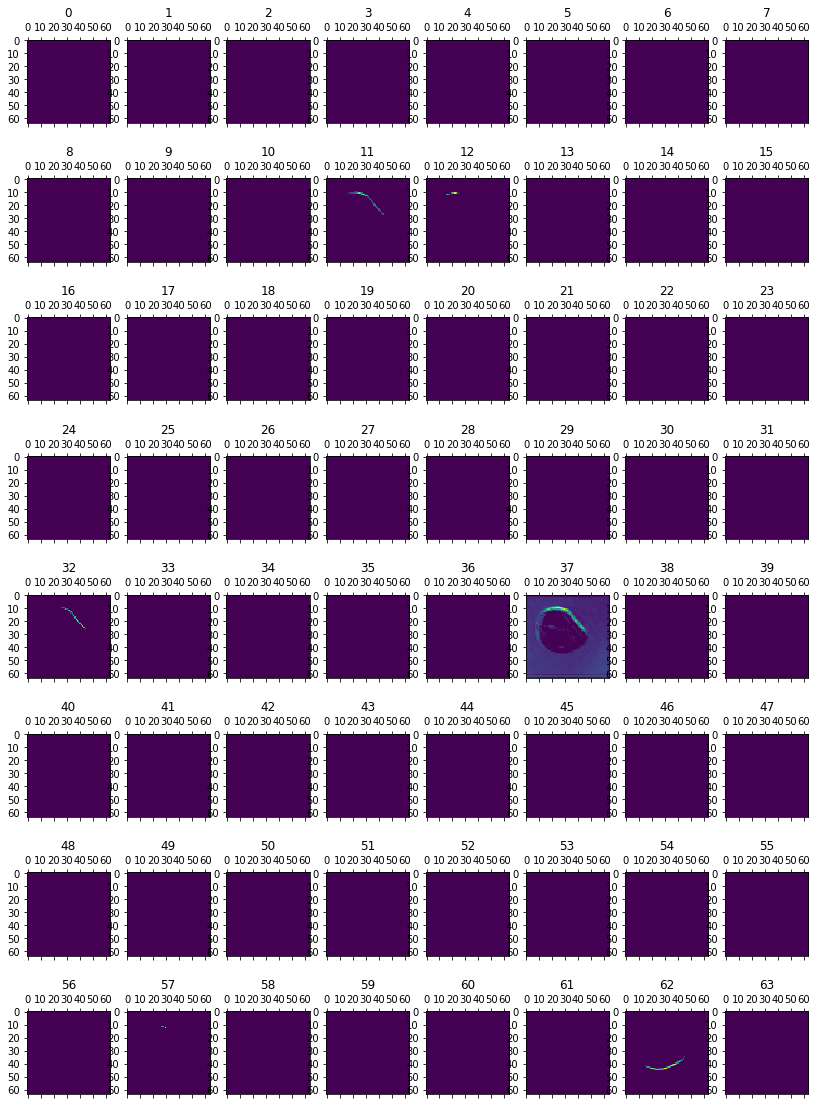

----------------
Geeting activations of layer 4 : pool_2
Images size is 32 x 32
Number of channels is 128
Printing channels:


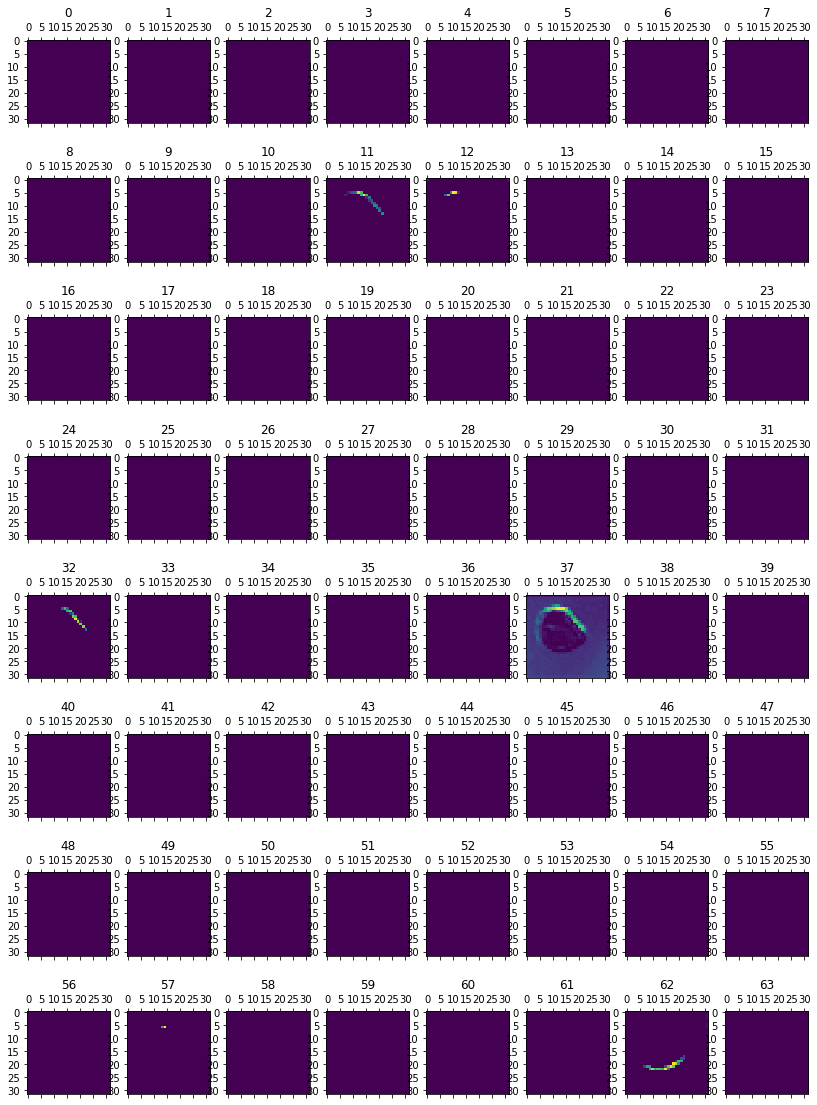

In [15]:
# outputs of the first 4 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')
        
        # define nrows and ncols depending on number of channels
        if idx in (0,1):
            nrows, ncols = 4,8
        if idx in (2,3):
            nrows, ncols = 8,8

        # plots
        channel=0
        if idx in (0,1):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        plt.show()

## Test Results
Evaluate model performance against the Test dataset

In [16]:
from sklearn import utils

XT = np.array(X_test)
YT = np.array(Y_test)

(XT, YT) = utils.shuffle(XT, YT)
test_results = model.evaluate(x=XT, y=YT)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

#test_results = model.evaluate(x=X_test, y=Y_test)

#print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

1/1 [==============================] - 0s 66ms/step - loss: 0.0797 - accuracy: 1.0000

Test Acc. 100.00%


In [17]:
# transform logits to probabilities
pred_logits = model.predict(XT)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

1/1 [==============================] - 0s 86ms/step


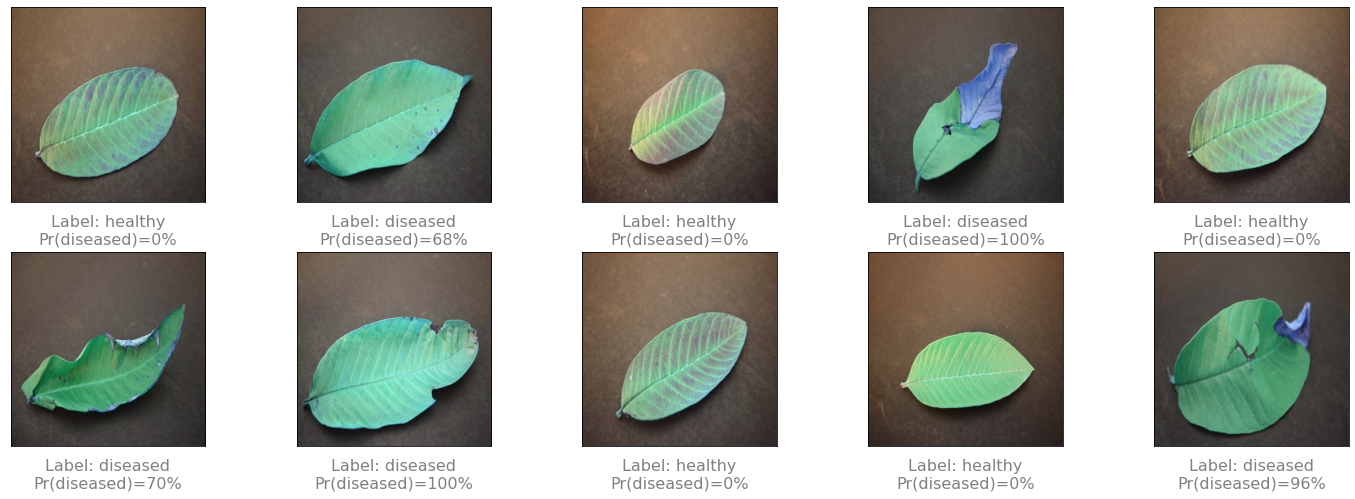

In [18]:
# plot test data and associated prediction
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(XT[0:30]):
    ax = fig.add_subplot(6,5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if YT[j]==0:
        label='healthy'
    else:
        label='diseased'
    
    ax.text(
        0.5, -0.15, 
        'Label: {:s}\nPr(diseased)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()